# **Function Approximation based Control for RL environments**

## Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

**Reference Book from which we are producing the figures for this project, and the equations & page numbers referered from is:**

**Reinforcement Learning: An Introduction (second edition) by Richard S. Sutton and Andrew G. Barto**

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import gym
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Semi-gradient SARSA with state aggregation implementation on Four Rooms Environment


In [3]:
""" Four Rooms Environment Implementation
"""
class FourRooms(object):
    def __init__(self):
        # We define the grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # We define the observation space consisting of all empty cells
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # We define the action space
        self.action_space = {'up': np.array([0, 1]),
                             'down': np.array([0, -1]),
                             'left': np.array([-1, 0]),
                             'right': np.array([1, 0])}
        self.action_names = ['up', 'down', 'left', 'right']

        # We define the start location
        self.start_location = [0, 0]

        # We define the goal location
        self.goal_location = [10, 10]

        # We find all wall cells
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, we define a timeout: maximal time steps = 459
        self.max_time_steps = 459

        # We define other useful variables
        self.agent_location = None  # track the agent's location in one episode.
        self.action = None  # track the agent's action
        self.t = 0  # track the current time step in one episode

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates to the Four Rooms coordinates (i.e, The origin locates at bottom left).
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): a list variable consists of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): a list variable consists of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # We reset the agent's location to the start location
        self.agent_location = self.start_location

        # We reset the timeout tracker to be 0
        self.t = 0

        # We set the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (string): a string variable (i.e., "UP"). All feasible values are ["up", "down", "left", "right"].
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == "left" or action == "right":
                action = np.random.choice(["up", "down"], 1)[0]
            else:
                action = np.random.choice(["right", "left"], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_space[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        # Compute the reward
        reward = 1.0 if next_agent_location == self.goal_location else 0.0

        # Check the termination
        # If the agent reaches the goal, reward = 1, done = True
        # If the time steps reaches the maximal number, reward = 0, done = True.
        if reward == 1.0 or self.t == self.max_time_steps:
            terminated = True
        else:
            terminated = False

        # Update the agent's location, action and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, False, {}

    def render(self):
        # plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        my_env = FourRooms()
        state, _ = my_env.reset()

        for _ in range(100):
            action = np.random.choice(list(my_env.action_space.keys()), 1)[0]

            next_state, reward, done, _, _ = my_env.step(action)
            my_env.render()

            if done:
                state, _ = my_env.reset()
            else:
                state = next_state

In [4]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    # save the figure
    plt.savefig(f"{fig_title}.png", dpi=200)

    plt.show()

# Implementing the semi-gradient SARSA

WE have implemented the semi-gradient SARSA with a very simple state aggregation strategy. That is aggregating both states and actions to itself. Indeed, this will have similar results as applying SARSA directly. 

**The following state aggregation strategy has been implemented here:**

- For each state, its aggregated state is itself. E.g. [0, 0] is aggregated to [0, 0] only. 
- For each action, its aggregated action is also itself.

In [5]:

class SemiGradientSARSAAgent(object):
    def __init__(self, env, info):
        """
        Function to initialize the semi-gradient SARSA agent
        Args:
            env: the environment that the agent interacts with
            info (dict): a dictionary variable contains all necessary parameters.

        Note that: Here, we fix the function approximation and only discuss different
                   state aggregation strategies. Specifically, we design the following function approximation:
                   1. Feature: we use the one-hot encoding to compute the feature for each state-action pair.
                               E.g., state = [0, 0] and action = "Up" will correspond to a unique one-hot representation
                                     [0, 0, 0, 1, 0, ..., 0].
                   2. Function approximation: we use the linear function approximation. Specifically, the approximation
                      function is represented by an N x 1 weight vector, where N = |S| * |A|.

        Importantly, we only aggregate the states.
        """
        # Store the environment
        self.env = env

        """ Learning parameters for semi-gradient SARSA """
        # Store the number of learning episodes
        self.episode_num = info['episode_num']

        # Store the Q-learning step size alpha
        self.alpha = info['alpha']

        # Store the discount factor
        self.gamma = info['gamma']

        # Initialize the epsilon
        self.epsilon = info['epsilon']

        # Store the hyerparameters
        self.params = info

        """ State aggregation for semi-gradient SARSA """
        # Compute the total number of state after the aggregation
        self.state_space, self.state_num = self.create_state_aggregation()

        # Compute the total number of the actions
        self.action_num = len(self.env.action_names)

        """ Function approximation for semi-gradient SARSA"""
        # We consider a linear function approximation here and store all the weights here
        self.weights_fn = np.zeros((self.state_num * self.action_num))

        # We construct a numpy array that contains the one-hot features for all states.
        # The size is (|S| * |A|) x (|S| * |A|)
        self.feature_arr = np.eye(self.state_num * self.action_num)

    def create_state_aggregation(self):
        """
        Function that returns the aggregated state space and the number of the aggregated states.
        """
        """Implementation of our state aggregation strategy. We start with a simple state aggregation
           that just aggregate each state to itself. In other words, the aggregated state space is just
           the original state space.
           
           We will then return:
            1. the aggregated state space (Any data structure that you find it easier to render the index of the 
               aggregated state.)
            2. the number of the aggregated states (int)
        """
        # Aggregation strategy: each state aggregates to itself, so the aggregated state space 
        # is the same as the original state space.
        aggregated_state_space = [tuple(state) for state in self.env.observation_space]  # Ensure states are tuples
        state_count = len(aggregated_state_space)
        return aggregated_state_space, state_count


    def _aggregate_state_idx(self, state):
        """
        Function returns the index of aggregated state given an original state

        Args:
            state (list): original state
        """
        """Based on our state aggregation, return the index of the aggregated state given an original
           state. 
           
           We return:
           1. index (int) of the aggregated state given the original state
        """
        # Convert state to tuple to ensure compatibility with state_space
        state_tuple = tuple(state)
        return self.state_space.index(state_tuple)
    

    def _aggregate_action_idx(self, action):
        """
        Function returns the index of aggregated action.
        Args:
            action (string): name of the action

        To be simple, here, one action only aggregates to itself
        """
        return self.env.action_names.index(action)

    def _get_state_action_feature(self, state, action):
        """
        Function that returns the one-hot feature given a state-action pair.

        Args:
            state (list): original state
            action (string): name of the action
        """
        # Get the unique index of the aggregated state
        state_index = self._aggregate_state_idx(state)
        # Get the unique index of the aggregated action
        action_index = self._aggregate_action_idx(action)
        # Compute the state(aggregated)-action index
        state_action_index = self.state_num * action_index + state_index
        # Get the one-hot feature of the state
        return self.feature_arr[state_action_index]

    def function_approximation(self, state, action):
        """
        Function that computes the Q value given a state-action pair using linear function approximation.
        Args:
            state (list): original state
            action (string): name of the action
        """
        state_action_feature = self._get_state_action_feature(state, action)
        return np.matmul(state_action_feature.T, self.weights_fn)

    def render_q_value(self, state, action):
        """
        Function that returns the Q value given a state-action pair

        Args:
            state (list): original state
            action (string): name of the action
        """
        return self.function_approximation(state, action)

    def epsilon_greedy_policy(self, state):
        """
        Function implements the epsilon-greedy policy
        Args:
            state (list): original state
        """
        """We implement the epsilon-greedy policy using function approximation. Break ties if happens """
        if np.random.rand() < self.epsilon:
            # Explore: choose a random action
            return np.random.choice(self.env.action_names)
        else:
            # Exploit: choose the action with the highest Q-value for this state
            q_values = [self.function_approximation(state, action) for action in self.env.action_names]
            max_q = max(q_values)
            # Handle tie-breaking in case of multiple actions with the same max Q-value
            best_actions = [self.env.action_names[i] for i, q in enumerate(q_values) if q == max_q]
            return np.random.choice(best_actions)
        

    def update_weights(self, s, a, r, s_prime, a_prime):
        """
        Function that updates the weights using semi-gradients

        Args:
            s (list): original state
            a (string): action name
            r (float): reward
            s_prime (list): original next state
            a_prime (string): next action name
        """
        """ Implementation of the update rule for semi-gradient SARSA """
        # Get the current Q-value and feature vector for (s, a)
        q_sa = self.function_approximation(s, a)
        feature_sa = self._get_state_action_feature(s, a)

        # Calculate the target using Q(s', a')
        if s_prime == self.env.goal_location:
            target = r  # If s' is terminal, target is just the reward
        else:
            q_s_prime_a_prime = self.function_approximation(s_prime, a_prime)
            target = r + self.gamma * q_s_prime_a_prime

        # Calculate the TD error
        td_error = target - q_sa

        # Update weights using the semi-gradient
        self.weights_fn += self.alpha * td_error * feature_sa
        

    def run(self):
        # Save the discounted return for each episode
        discounted_returns = []

        # Semi-gradient SARSA starts
        for ep in tqdm.trange(self.episode_num):
            """Implementation of the pseudocode of Semi-gradient SARSA"""
            # Reset the agent to initial STATE at the beginning of every episode
            state, _ = self.env.reset()
            # Render an ACTION based on the initial STATE
            action = self.epsilon_greedy_policy(state)
            # Store rewards to compute return G for the current episode.
            reward_list = []
            
            # Loop the episode
            for t in range(self.env.max_time_steps):
                # Take the ACTION and observe REWARD and NEXT STATE
                next_state, reward, done, _, _ = self.env.step(action)
                # Given the NEXT STATE, choose the NEXT ACTION
                if not done:
                    next_action = self.epsilon_greedy_policy(next_state)
                else:
                    next_action = None  # No next action if the episode is done

                # Update the weights of the function using semi-gradient SARSA
                # Using STATE, ACTION, REWARD, NEXT STATE, NEXT ACTION
                if next_action is not None:
                    self.update_weights(state, action, reward, next_state, next_action)
                else:
                    # Final update if the episode ends in the next state
                    self.update_weights(state, action, reward, next_state, None)
                
                # Save the reward for plotting
                reward_list.append(reward)

                # Reset the environment
                if done:
                    break
                else:
                    state = next_state
                    action = next_action

            # compute the discounted return for the current episode
            G = 0
            for reward in reversed(reward_list):
                G = reward + self.gamma * G
            discounted_returns.append(G)

        return discounted_returns
           

100%|██████████| 100/100 [00:01<00:00, 62.66it/s]


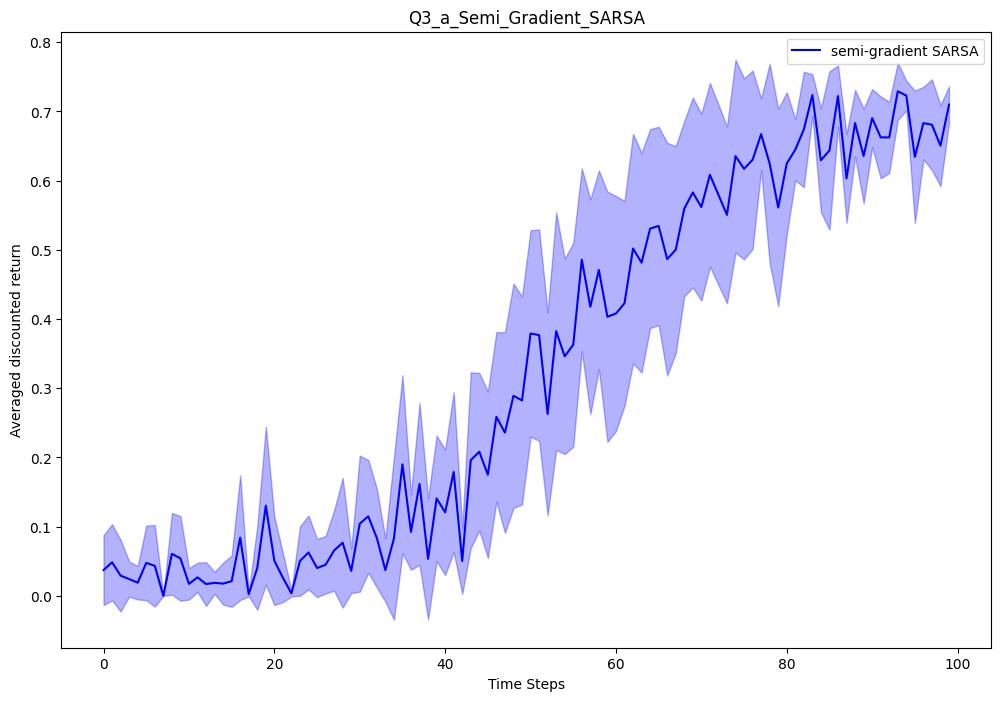

In [29]:
if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params = {
        "episode_num": 100,
        "alpha": 0.1,
        "gamma": 0.99,
        "epsilon": 0.1,
        'tile_size': 1
    }

    # set running trials
    run_trial = 10

    results_1 = []
    for _ in range(run_trial):
        # create the environment
        my_env = FourRooms()

        # run semi-gradient SARSA with tile n = 2
        tabular_sarsa = SemiGradientSARSAAgent(my_env, params)
        res = tabular_sarsa.run()

        # save result for each running trial
        results_1.append(np.array(res))

    plot_curves([np.array(results_1)],
                ["semi-gradient SARSA"],
                ["b"],
                "Averaged discounted return", "Q3_a_Semi_Gradient_SARSA")

# Implementatiob of the semi-gradient SARSA with Tile-based/Room-based aggregation.

We have implemented the semi-gradient SARSA with **Tile-based/Room-based** state aggregation strategy. That is grouping the nearby states in a n x n (i.e., n = 2) tile as one aggregated state. As for the function approximation, we assume to use the same as above.  

**Plot**: We will plot the learning curves of tile size n = 2 and Room-based aggregation in the same plot. We will use the plot function above to generate the plot. 

In [6]:
""" Implementatiob of the Tile-based Agent here. We inherit it from the "SemiGradientSARSAAgent" above
"""
class TileAgent(SemiGradientSARSAAgent):
    def __init__(self, env, info):
        """
        Function to initialize the semi-gradient SARSA agent
        Args:
            env: the environment that the agent interacts with
            info (dict): a dictionary variable contains all necessary parameters.

        Note that: Here, we will implement a simple state aggregation strategies.
                   Specifically, we design the following function approximation:
                   1. Feature: we use the one-hot encoding to compute the feature for each state-action pair.
                               E.g., state = [0, 0] and action = "Up" (state-action pair) will correspond to
                               a unique one-hot representation $f(s, a) = [0, 0, 0, 1, 0, ..., 0]$.
                   2. Weights: we define a weight vector $w$ having the sample shape as the feature vector.
                               Specifically, the Q(s, a) can be estimated by Q(s, a) = w^{T} * f(s, a)

        Importantly, we only aggregate the states.
        """
        super().__init__(env, info)
        
        """ State aggregation for semi-gradient SARSA """
        # Compute the total number of state after the aggregation
        self.state_space, self.state_num = self.create_state_aggregation()

        # Compute the total number of the actions
        self.action_num = len(self.env.action_names)

        """ Function approximation for semi-gradient SARSA"""
        # We create a weight with shape |S| * |A|
        self.weights_fn = np.zeros((self.state_num * self.action_num))

        # We construct a numpy array that contains the one-hot features for all state-action pairs.
        # The size is (|S| * |A|) x (|S| * |A|).
        # Each i-th row is the one-hot encoding for state-action pair with index i.
        self.feature_arr = np.eye(self.state_num * self.action_num)

    def create_state_aggregation(self):
        """
        Function that returns the aggregated state space and the number of the aggregated states.
        """
        
        """Implementation of the Tile-based state aggregation here.
           We manually discretize the original states using the Tile-based method.
           For example, we can copy the grid from the Four Rooms environment
           and manually aggregate the states (value = 0) in the grid. 
           
           We return:
            1. the aggregated state space (Any data structure that you find it easier to render the index of the 
               aggregated state.)
            2. the number of the aggregated states (int)
        """
        
        # define the aggregated state space using Tile-based method (2x2)
        grid = self.env.grid.shape
        aggregated_state_space = {}
        state_id = 0

        # aggregate the state space
        # Loop over the grid in steps of 2 to create 2x2 tiles
        for y in range(0, grid[0], 2):
            for x in range(0, grid[1], 2):
                # Aggregate all positions within a 2x2 tile
                for dy in range(2):
                    for dx in range(2):
                        pos = (x + dx, y + dy)
                        if pos in self.env.observation_space:
                            aggregated_state_space[pos] = state_id
                state_id += 1

        return aggregated_state_space, state_id

    def _aggregate_state_idx(self, state):
        """
        Function returns the index of aggregated state given an original state

        Args:
            state (list): original state
        """
        """Based on our state aggregation, we return the index of the aggregated state given an original
           state. 
           
           You have to return:
           1. index (int) of the aggregated state given the original state
        """
        
        # render the index of the aggregated state
        # Retrieve index of the aggregated state
        return self.state_space[tuple(state)]

In [7]:
""" Implementation of the Room-based Agent here. We inherit it from the "SemiGradientSARSAAgent" above
"""
class RoomAgent(SemiGradientSARSAAgent):
    def __init__(self, env, info):
        """
        Function to initialize the semi-gradient SARSA agent
        Args:
            env: the environment that the agent interacts with
            info (dict): a dictionary variable contains all necessary parameters.

        Note that: Here, we will implement a simple state aggregation strategies.
                   Specifically, we design the following function approximation:
                   1. Feature: we use the one-hot encoding to compute the feature for each state-action pair.
                               E.g., state = [0, 0] and action = "Up" (state-action pair) will correspond to
                               a unique one-hot representation $f(s, a) = [0, 0, 0, 1, 0, ..., 0]$.
                   2. Weights: we define a weight vector $w$ having the sample shape as the feature vector.
                               Specifically, the Q(s, a) can be estimated by Q(s, a) = w^{T} * f(s, a)

        Importantly, we only aggregate the states. 
        """
        super().__init__(env, info)
        
        """ State aggregation for semi-gradient SARSA """
        # Compute the total number of state after the aggregation
        self.state_space, self.state_num = self.create_state_aggregation()

        # Compute the total number of the actions
        self.action_num = len(self.env.action_names)

        """ Function approximation for semi-gradient SARSA"""
        # We create a weight with shape |S| * |A|
        self.weights_fn = np.zeros((self.state_num * self.action_num))

        # We construct a numpy array that contains the one-hot features for all state-action pairs.
        # The size is (|S| * |A|) x (|S| * |A|).
        # Each i-th row is the one-hot encoding for state-action pair with index i.
        self.feature_arr = np.eye(self.state_num * self.action_num)

    def create_state_aggregation(self):
        """
        Function that returns the aggregated state space and the number of the aggregated states.
        """
        """This is our state aggregation strategy. We start with a simple state aggregation
           that just aggregate each state to itself. In other words, the aggregated state space is just
           the original state space.
           
           We return:
            1. the aggregated state space (Any data structure that you find it easier to render the index of the 
               aggregated state.)
            2. the number of the aggregated states (int)
        """

        # Define room boundaries manually
        room1 = [(x, y) for x in range(6) for y in range(5, 11)]
        room2 = [(x, y) for x in range(6, 11) for y in range(5, 11)]
        room3 = [(x, y) for x in range(6) for y in range(0, 5)]
        room4 = [(x, y) for x in range(6, 11) for y in range(0, 5)]

        # aggregate the state space
        # Map each state to a room-based aggregated state
        aggregated_state_space = {}
        room_mapping = [room1, room2, room3, room4]
        for idx, room in enumerate(room_mapping):
            for pos in room:
                if pos in self.env.observation_space:
                    aggregated_state_space[pos] = idx

        return aggregated_state_space, len(room_mapping)

    def _aggregate_state_idx(self, state):
        """
        Function returns the index of aggregated state given an original state

        Args:
            state (list): original state
        """
        """Based on the state aggregation, return the index of the aggregated state given an original
           state. 
           
           We will return:
           1. index (int) of the aggregated state given the original state
        """
        return self.state_space[tuple(state)]

In [32]:
if __name__ == "__main__":
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # set hyper-parameters
    params = {
        "episode_num": 100,
        "alpha": 0.1,
        "gamma": 0.99,
        "epsilon": 0.1
    }

    # set running trials; You can trial run_trial = 5 to debug
    run_trial = 10

    # run experiment for the Tile-based method
    results_tile = []
    for _ in range(run_trial):        
        # create the environment
        my_env = FourRooms()

        # run semi-gradient SARSA with Tile-based method with tile size n = 2
        my_agent = TileAgent(my_env, params)
        res = my_agent.run()

        # save result for each running trial
        results_tile.append(np.array(res))
        
    # run experiment for the Room-based method
    results_room = []
    for _ in range(run_trial):        
        # create the environment
        my_env = FourRooms()

        # run semi-gradient SARSA with Room-based method
        my_agent = RoomAgent(my_env, params)
        res = my_agent.run()    

        # save result for each running trial
        results_room.append(np.array(res))

100%|██████████| 100/100 [00:00<00:00, 157.65it/s]


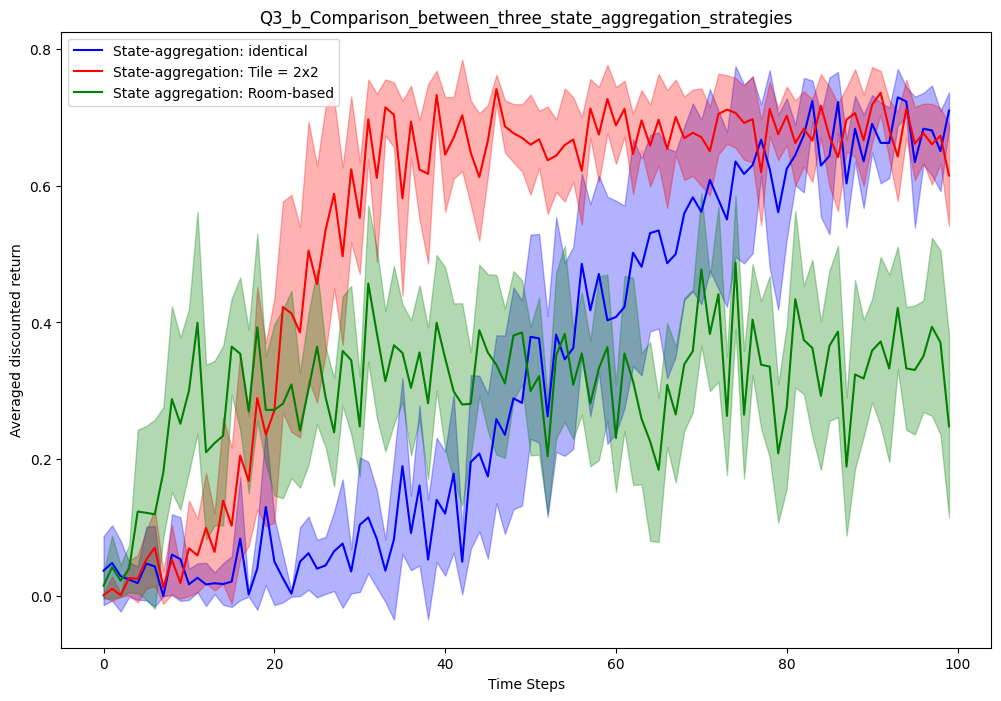

In [33]:
# plot the results
plot_curves([np.array(results_1), np.array(results_tile), np.array(results_room)],
            ["State-aggregation: identical", "State-aggregation: Tile = 2x2", "State aggregation: Room-based"],
            ["b", "r", "g"],
            "Averaged discounted return", "Q3_b_Comparison_between_three_state_aggregation_strategies")

# Adapt our implementation of semi-gradient one-step SARSA for linear function approximation

In [8]:
class LinearSemiGradientSARSAAgent(SemiGradientSARSAAgent):
    def __init__(self, env, info):
        # Call the superclass constructor to initialize common parameters
        super().__init__(env, info)
        
        # Override the function approximation parameters
        # We have 3 state features (x, y, 1) and 4 actions, so total features = 3 + 4 = 7
        self.feature_dim = 3 + len(self.env.action_names)
        # Initialize weights for linear function approximation
        self.weights_fn = np.zeros(self.feature_dim)
        # Map action names to indices for one-hot encoding
        self.action_indices = {action_name: idx for idx, action_name in enumerate(self.env.action_names)}
    
    def _get_state_action_feature(self, state, action):
        """
        Function that returns the feature vector given a state-action pair.

        Args:
            state (list): original state
            action (string): name of the action
        """
        # State features: x coordinate, y coordinate, and bias term
        x, y = state
        phi_s = np.array([x, y, 1])
        # Action features: one-hot encoding of the action
        action_one_hot = np.zeros(len(self.env.action_names))
        action_idx = self.action_indices[action]
        action_one_hot[action_idx] = 1
        # Combine state and action features
        phi = np.concatenate([phi_s, action_one_hot])
        return phi

    def function_approximation(self, state, action):
        """
        Function that computes the Q value given a state-action pair using linear function approximation.
        Args:
            state (list): original state
            action (string): name of the action
        """
        phi = self._get_state_action_feature(state, action)
        return np.dot(self.weights_fn, phi)

    def update_weights(self, s, a, r, s_prime, a_prime):
        """
        Function that updates the weights using semi-gradients

        Args:
            s (list): original state
            a (string): action name
            r (float): reward
            s_prime (list): original next state
            a_prime (string): next action name
        """
        # Get the current Q-value and feature vector for (s, a)
        phi_s = self._get_state_action_feature(s, a)
        q_sa = np.dot(self.weights_fn, phi_s)

        # Calculate the target using Q(s', a')
        if s_prime is not None and a_prime is not None:
            q_s_prime_a_prime = self.function_approximation(s_prime, a_prime)
            target = r + self.gamma * q_s_prime_a_prime
        else:
            target = r  # If s' is terminal, target is just the reward

        # Calculate the TD error
        td_error = target - q_sa

        # Update weights using the semi-gradient
        self.weights_fn += self.alpha * td_error * phi_s



100%|██████████| 100/100 [00:02<00:00, 35.11it/s]


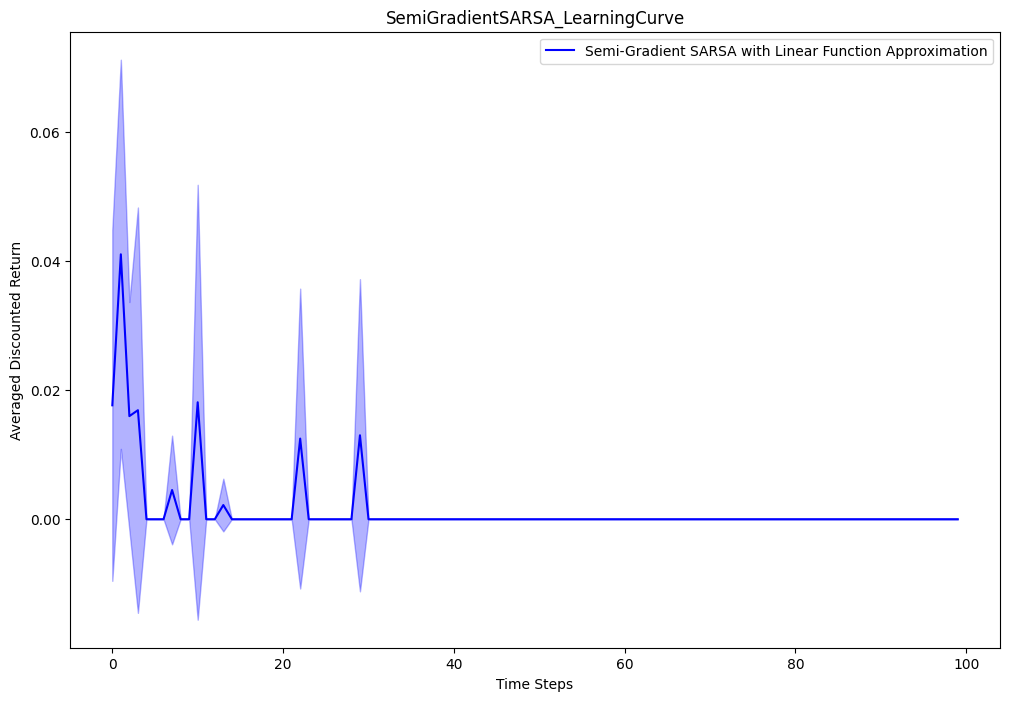

In [52]:
if __name__ == "__main__":
    # Set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # Set hyper-parameters
    params = {
        "episode_num": 100,
        "alpha": 0.1,  # Adjusted learning rate for stability
        "gamma": 0.99,
        "epsilon": 0.1,
    }

    # Set running trials
    run_trial = 10

    results_1 = []
    for _ in range(run_trial):
        # Create the environment
        my_env = FourRooms()

        # Run semi-gradient SARSA with the specified features
        sarsa_agent = LinearSemiGradientSARSAAgent(my_env, params)
        res = sarsa_agent.run()

        # Save result for each running trial
        results_1.append(np.array(res))

    plot_curves([np.array(results_1)],
                ["Semi-Gradient SARSA with Linear Function Approximation"],
                ["b"],
                "Averaged Discounted Return",
                "SemiGradientSARSA_LearningCurve")


100%|██████████| 100/100 [00:02<00:00, 40.13it/s]


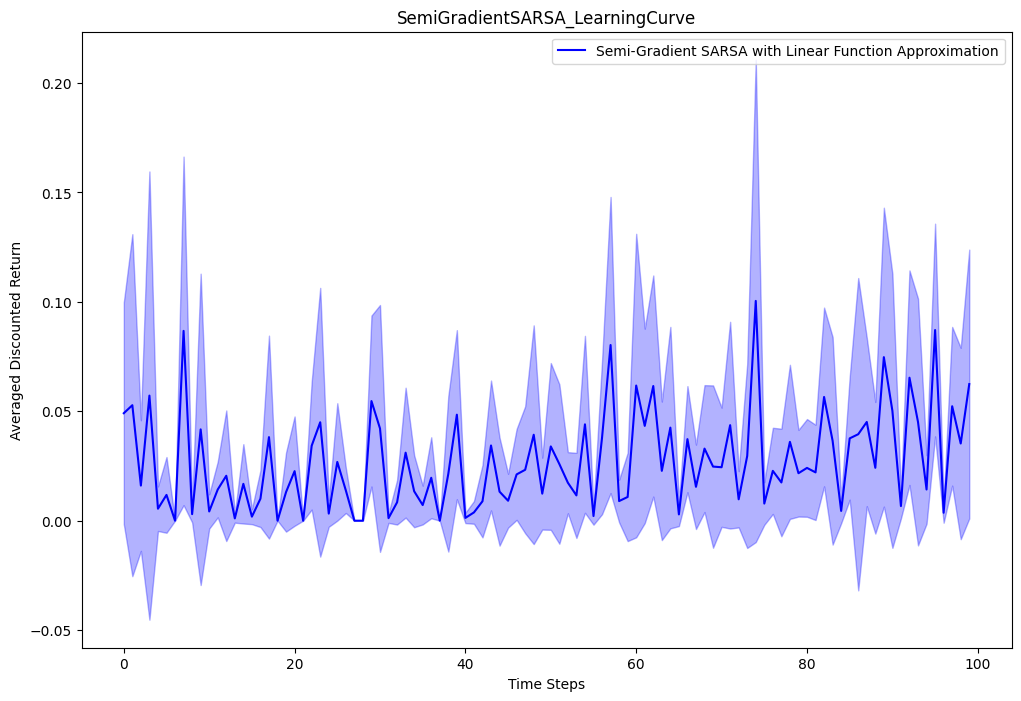

In [53]:
if __name__ == "__main__":
    # Set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # Set hyper-parameters
    params = {
        "episode_num": 100,
        "alpha": 0.001,  # Adjusted learning rate for stability
        "gamma": 0.99,
        "epsilon": 0.1,
    }

    # Set running trials
    run_trial = 10

    results_1 = []
    for _ in range(run_trial):
        # Create the environment
        my_env = FourRooms()

        # Run semi-gradient SARSA with the specified features
        sarsa_agent = LinearSemiGradientSARSAAgent(my_env, params)
        res = sarsa_agent.run()

        # Save result for each running trial
        results_1.append(np.array(res))

    plot_curves([np.array(results_1)],
                ["Semi-Gradient SARSA with Linear Function Approximation"],
                ["b"],
                "Averaged Discounted Return",
                "SemiGradientSARSA_LearningCurve")


# Implementation of the following two features, and plotting the learning curves.

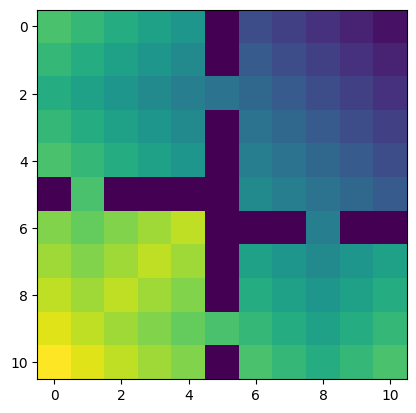

In [9]:
"""The distance matrix is here"""

distance_matrix = np.array([[14, 13, 12, 11, 10, -1,  4,  3,  2,  1,  0],
                            [13, 12, 11, 10,  9, -1,  5,  4,  3,  2,  1],
                            [12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2],
                            [13, 12, 11, 10,  9, -1,  7,  6,  5,  4,  3],
                            [14, 13, 12, 11, 10, -1,  8,  7,  6,  5,  4],
                            [-1, 14, -1, -1, -1, -1,  9,  8,  7,  6,  5],
                            [16, 15, 16, 17, 18, -1, -1, -1,  8, -1, -1],
                            [17, 16, 17, 18, 17, -1, 11, 10,  9, 10, 11],
                            [18, 17, 18, 17, 16, -1, 12, 11, 10, 11, 12],
                            [19, 18, 17, 16, 15, 14, 13, 12, 11, 12, 13],
                            [20, 19, 18, 17, 16, -1, 14, 13, 12, 13, 14]])
plt.imshow(distance_matrix)
plt.show()

In [10]:
class NormalizedCoordinatesSemiGradientSARSAAgent(SemiGradientSARSAAgent):
    def __init__(self, env, info):
        super().__init__(env, info)
        # Features: [x/10, y/10, 1] + action one-hot encoding
        self.feature_dim = 3 + len(self.env.action_names)
        self.weights_fn = np.zeros(self.feature_dim)
        self.action_indices = {action_name: idx for idx, action_name in enumerate(self.env.action_names)}

    def _get_state_action_feature(self, state, action):
        x, y = state
        phi_s = np.array([x/10, y/10, 1])
        # Action features
        action_one_hot = np.zeros(len(self.env.action_names))
        action_idx = self.action_indices[action]
        action_one_hot[action_idx] = 1
        # Combine features
        phi = np.concatenate([phi_s, action_one_hot])
        return phi

    def function_approximation(self, state, action):
        phi = self._get_state_action_feature(state, action)
        return np.dot(self.weights_fn, phi)

    def update_weights(self, s, a, r, s_prime, a_prime):
        # Same as before
        phi_s = self._get_state_action_feature(s, a)
        q_sa = np.dot(self.weights_fn, phi_s)
        if s_prime is not None and a_prime is not None:
            q_s_prime_a_prime = self.function_approximation(s_prime, a_prime)
            target = r + self.gamma * q_s_prime_a_prime
        else:
            target = r
        td_error = target - q_sa
        self.weights_fn += self.alpha * td_error * phi_s

class DistanceFeatureSemiGradientSARSAAgent(SemiGradientSARSAAgent):
    def __init__(self, env, info):
        super().__init__(env, info)
        # Features: [d, x, y, 1] + action one-hot encoding
        self.feature_dim = 4 + len(self.env.action_names)
        self.weights_fn = np.zeros(self.feature_dim)
        self.action_indices = {action_name: idx for idx, action_name in enumerate(self.env.action_names)}
        # Define the distance matrix
        self.distance_matrix = np.array([[14, 13, 12, 11, 10, -1,  4,  3,  2,  1,  0],
                                         [13, 12, 11, 10,  9, -1,  5,  4,  3,  2,  1],
                                         [12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2],
                                         [13, 12, 11, 10,  9, -1,  7,  6,  5,  4,  3],
                                         [14, 13, 12, 11, 10, -1,  8,  7,  6,  5,  4],
                                         [-1, 14, -1, -1, -1, -1,  9,  8,  7,  6,  5],
                                         [16, 15, 16, 17, 18, -1, -1, -1,  8, -1, -1],
                                         [17, 16, 17, 18, 17, -1, 11, 10,  9, 10, 11],
                                         [18, 17, 18, 17, 16, -1, 12, 11, 10, 11, 12],
                                         [19, 18, 17, 16, 15, 14, 13, 12, 11, 12, 13],
                                         [20, 19, 18, 17, 16, -1, 14, 13, 12, 13, 14]])

    def _get_state_action_feature(self, state, action):
        x, y = state
        # Compute d
        row_idx = 10 - y
        col_idx = x
        d = self.distance_matrix[row_idx, col_idx]
        # Handle walls (-1)
        if d == -1:
            d = 20  # Assign a large value
        phi_s = np.array([d, x, y, 1])
        # Action features
        action_one_hot = np.zeros(len(self.env.action_names))
        action_idx = self.action_indices[action]
        action_one_hot[action_idx] = 1
        # Combine features
        phi = np.concatenate([phi_s, action_one_hot])
        return phi

    def function_approximation(self, state, action):
        phi = self._get_state_action_feature(state, action)
        return np.dot(self.weights_fn, phi)

    def update_weights(self, s, a, r, s_prime, a_prime):
        # Same as before
        phi_s = self._get_state_action_feature(s, a)
        q_sa = np.dot(self.weights_fn, phi_s)
        if s_prime is not None and a_prime is not None:
            q_s_prime_a_prime = self.function_approximation(s_prime, a_prime)
            target = r + self.gamma * q_s_prime_a_prime
        else:
            target = r
        td_error = target - q_sa
        self.weights_fn += self.alpha * td_error * phi_s

100%|██████████| 100/100 [00:02<00:00, 38.86it/s]


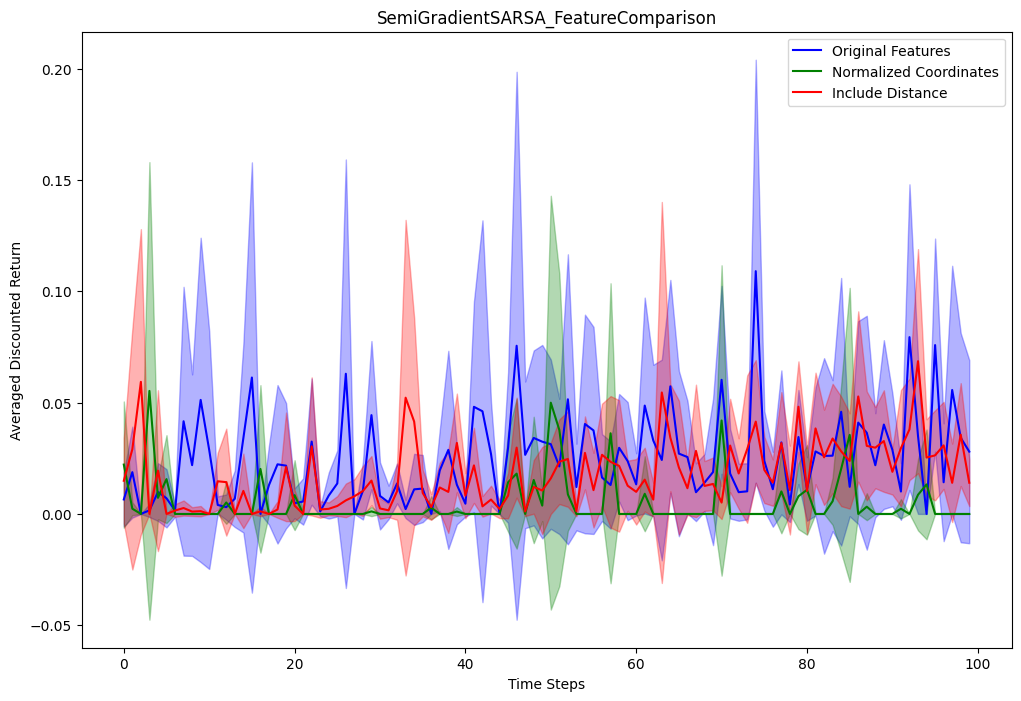

In [51]:
if __name__ == "__main__":
    # Set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # Set hyper-parameters
    params = {
        "episode_num": 100,
        "alpha": 0.001,  # Adjusted learning rate
        "gamma": 0.99,
        "epsilon": 0.1,
    }

    # Set running trials
    run_trial = 10

    results_original = []
    results_normalized = []
    results_distance = []
    for _ in range(run_trial):
        # Create the environment
        my_env = FourRooms()

        # Run semi-gradient SARSA with original features
        agent_original = LinearSemiGradientSARSAAgent(my_env, params)
        res_original = agent_original.run()
        results_original.append(np.array(res_original))

        # Run semi-gradient SARSA with normalized coordinates
        agent_normalized = NormalizedCoordinatesSemiGradientSARSAAgent(my_env, params)
        res_normalized = agent_normalized.run()
        results_normalized.append(np.array(res_normalized))

        # Run semi-gradient SARSA with distance feature
        agent_distance = DistanceFeatureSemiGradientSARSAAgent(my_env, params)
        res_distance = agent_distance.run()
        results_distance.append(np.array(res_distance))

    # Plotting the results
    plot_curves([np.array(results_original), np.array(results_normalized), np.array(results_distance)],
                ["Original Features", "Normalized Coordinates", "Include Distance"],
                ["b", "g", "r"],
                "Averaged Discounted Return",
                "SemiGradientSARSA_FeatureComparison")

100%|██████████| 1000/1000 [00:20<00:00, 48.22it/s]


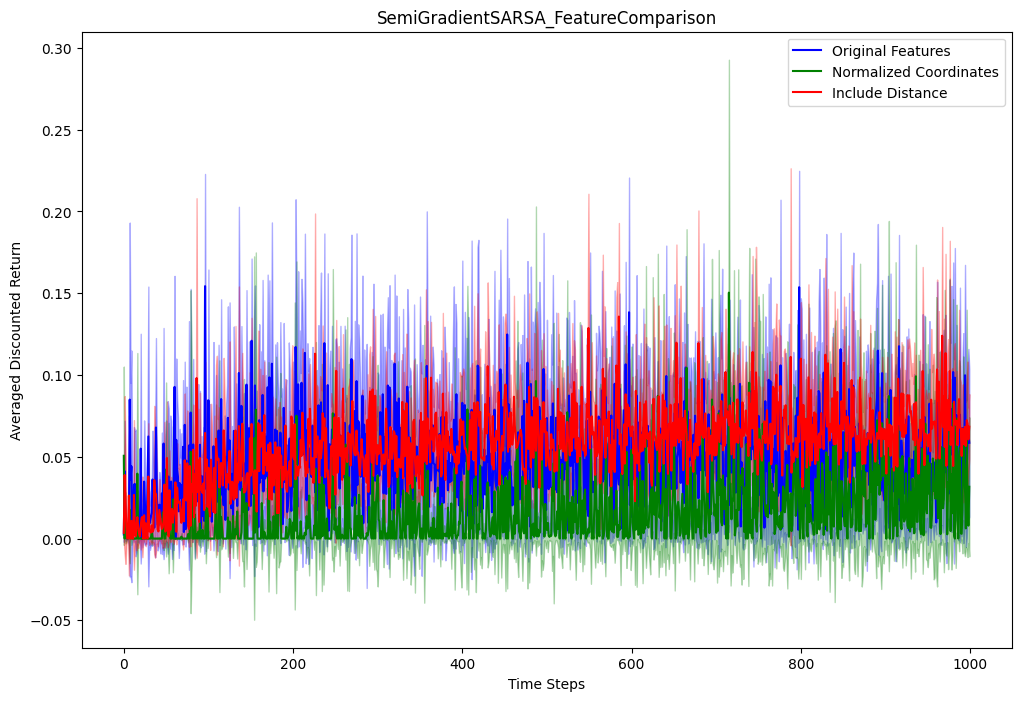

In [50]:
if __name__ == "__main__":
    # Set the random seed
    np.random.seed(1234)
    random.seed(1234)

    # Set hyper-parameters
    params = {
        "episode_num": 1000,
        "alpha": 0.001,  # Adjusted learning rate
        "gamma": 0.99,
        "epsilon": 0.1,
    }

    # Set running trials
    run_trial = 10

    results_original = []
    results_normalized = []
    results_distance = []
    for _ in range(run_trial):
        # Create the environment
        my_env = FourRooms()

        # Run semi-gradient SARSA with original features
        agent_original = LinearSemiGradientSARSAAgent(my_env, params)
        res_original = agent_original.run()
        results_original.append(np.array(res_original))

        # Run semi-gradient SARSA with normalized coordinates
        agent_normalized = NormalizedCoordinatesSemiGradientSARSAAgent(my_env, params)
        res_normalized = agent_normalized.run()
        results_normalized.append(np.array(res_normalized))

        # Run semi-gradient SARSA with distance feature
        agent_distance = DistanceFeatureSemiGradientSARSAAgent(my_env, params)
        res_distance = agent_distance.run()
        results_distance.append(np.array(res_distance))

    # Plotting the results
    plot_curves([np.array(results_original), np.array(results_normalized), np.array(results_distance)],
                ["Original Features", "Normalized Coordinates", "Include Distance"],
                ["b", "g", "r"],
                "Averaged Discounted Return",
                "SemiGradientSARSA_FeatureComparison")

# Mountain car environment
### Here, we eill use the mountain car env from gymnasium
link: https://gymnasium.farama.org/environments/classic_control/mountain_car/

We also use the code in tiles3.py from https://github.com/kamenbliznashki/sutton_barto/blob/master/tiles3.py to help with the implementation of our code.

In [ ]:
# Class IHT: Handles collision resolution in a hash table-like structure for efficient storage and retrieval.
class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        # Initialize the size of the hash table, set collision counter, and prepare an empty dictionary for storage.
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def count(self):
        # Returns the current count of unique items stored in the hash table.
        return len(self.dictionary)

    def getindex(self, obj, readonly=False):
        # Fetches the index for the provided object. If it doesn't exist and readonly is False,
        # assigns a new index if within capacity; otherwise, uses a hash-based fallback in case of overflow.
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif readonly:
            return None
        else:
            count = self.count()
            if count >= self.size:
                # Handle overflow by using a hash-based index and increment the collision count.
                if self.overfullCount == 0:
                    print('IHT full, starting to allow collisions')
                self.overfullCount += 1
                return hash(obj) % self.size
            else:
                # Assign a new index to the object within the hash table size capacity.
                d[obj] = count
                return count

# tiles function: Implements tile coding to map continuous input features (floats) to discrete tile indices.
def tiles(ihtORsize, numtilings, floats, ints=[]):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [int(f * numtilings) for f in floats]  # Scale floats based on the number of tilings
    tiles = []  # Initialize the list of tile indices
    for tiling in range(numtilings):
        coords = [tiling]  # Start with the tiling number for unique coordinates
        for i in range(len(qfloats)):
            # Compute the coordinate for each float feature, adjusted by the tiling
            coords.append((qfloats[i] + tiling) // numtilings)
        coords.extend(ints)  # Append integer-based features (if any)
        tiles.append(hashcoords(coords, ihtORsize))  # Map the coordinates to a tile index
    return tiles

# hashcoords function: Hashes a given set of coordinates to an index, using either IHT or direct hashing.
def hashcoords(coordinates, ihtORsize):
    if isinstance(ihtORsize, IHT):
        return ihtORsize.getindex(tuple(coordinates))  # Use IHT for managing collisions and indexing
    elif isinstance(ihtORsize, int):
        return hash(tuple(coordinates)) % ihtORsize  # Direct hashing if only size is given
    else:
        return tuple(coordinates)  # Return coordinates directly if neither IHT nor size is provided


In [ ]:
# Class SemiGradientSARSAAgent: Implements a Semi-Gradient SARSA agent using tile coding for function approximation
class SemiGradientSARSAAgent:
    def __init__(self, env, info):
        # Initialize environment and learning parameters from 'info' dictionary.
        self.env = env
        self.episode_num = info['episode_num']
        self.alpha = info['alpha']
        self.gamma = info['gamma']
        self.epsilon = info['epsilon']
        self.num_tilings = info['num_tilings']
        self.max_size = info['max_size']

        # Initialize weights for tile-coded function approximation and action space.
        self.iht = IHT(self.max_size)
        self.w = np.zeros(self.max_size)
        self.num_actions = env.action_space.n

        # Set scaling factors for continuous state variables for use with tile coding.
        self.position_scale = self.num_tilings / (env.observation_space.high[0] - env.observation_space.low[0])
        self.velocity_scale = self.num_tilings / (env.observation_space.high[1] - env.observation_space.low[1])

    def get_tiles(self, state, action):
        # Converts continuous state variables to tile indices, encoding the state-action pair for the agent.
        position, velocity = state
        scaled_state = [position * self.position_scale, velocity * self.velocity_scale]
        active_tiles = tiles(self.iht, self.num_tilings, scaled_state, [action])
        return active_tiles

    def q_hat(self, state, action):
        # Approximates the Q-value of the given state-action pair by summing the weights of active tiles.
        active_tiles = self.get_tiles(state, action)
        return np.sum(self.w[active_tiles])

    def choose_action(self, state):
        # Selects an action using an epsilon-greedy policy to balance exploration and exploitation.
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Exploration
        else:
            # Exploitation: choose the action with the maximum estimated Q-value.
            q_values = [self.q_hat(state, a) for a in range(self.num_actions)]
            max_q = max(q_values)
            max_actions = [a for a, q in enumerate(q_values) if q == max_q]
            return random.choice(max_actions)

    def update(self, state, action, reward, next_state, next_action):
        # Performs the semi-gradient SARSA weight update based on the temporal-difference (TD) error.
        active_tiles = self.get_tiles(state, action)
        q_sa = self.q_hat(state, action)

        # Calculate next state's Q-value if available; otherwise, use zero for terminal state.
        if next_state is not None and next_action is not None:
            q_sa_next = self.q_hat(next_state, next_action)
        else:
            q_sa_next = 0

        # Calculate the TD error and update weights for the active tiles.
        td_error = reward + self.gamma * q_sa_next - q_sa
        self.w[active_tiles] += self.alpha * td_error

    def run(self):
        # Main loop for running episodes and tracking the number of steps per episode.
        steps_per_episode = []
        for ep in tqdm.trange(self.episode_num):
            state, _ = self.env.reset()
            action = self.choose_action(state)
            total_steps = 0
            done = False

            while not done:
                # Take a step in the environment, get the result, and update the policy and weights.
                next_state, reward, done, _, _ = self.env.step(action)
                if done and next_state[0] >= 0.5:
                    # Goal reached, no further action needed.
                    next_action = None
                else:
                    # Choose the next action for continuing the episode.
                    next_action = self.choose_action(next_state)

                # Update weights using SARSA update.
                self.update(state, action, reward, next_state if not done else None, next_action)

                # Transition to the next state and action.
                state = next_state
                action = next_action
                total_steps += 1

                if total_steps >= 200:
                    # End episode if step limit is reached.
                    break

            steps_per_episode.append(total_steps)  # Track steps taken for this episode

        return steps_per_episode  # Return steps taken per episode for analysis


In [ ]:
def plot_learning_curves(results, alphas):
    # Plot the learning curves of the agent's performance over episodes for different alpha values
    plt.figure(figsize=(10, 6))
    for steps_per_episode, alpha in zip(results, alphas):
        # For each alpha, plot the number of steps taken per episode
        episodes = range(len(steps_per_episode))
        plt.plot(episodes, steps_per_episode, label=f'α = {alpha}')
    plt.xlabel('Episode')
    plt.ylabel('Steps per Episode')
    plt.title('Learning Curves for Semi-Gradient SARSA with Tile Coding')
    plt.legend()
    plt.grid(True)
    plt.show()

### THIS FUNCTION IS FOR THE 2D PLOT VISUALIZATION FOR THE COST-TO-GO FUNCTION
def plot_cost_to_go(agent, num_tiles=50, episode=None):
    # Visualize the agent's cost-to-go function, which approximates the negative of the maximum Q-value across actions
    position_min, position_max = agent.env.observation_space.low[0], agent.env.observation_space.high[0]
    velocity_min, velocity_max = agent.env.observation_space.low[1], agent.env.observation_space.high[1]
    
    # Define ranges for position and velocity based on the environment's observation space
    position_range = np.linspace(position_min, position_max, num_tiles)
    velocity_range = np.linspace(velocity_min, velocity_max, num_tiles)
    cost_to_go = np.zeros((num_tiles, num_tiles))

    # Compute cost-to-go values over a grid of position and velocity states
    for i, pos in enumerate(position_range):
        for j, vel in enumerate(velocity_range):
            state = np.array([pos, vel])
            # Calculate Q-values for all actions in the given state and store the negative maximum
            q_values = [agent.q_hat(state, a) for a in range(agent.num_actions)]
            cost_to_go[j, i] = -np.max(q_values)

    # Plot the cost-to-go function as a contour map
    plt.figure(figsize=(10, 6))
    X, Y = np.meshgrid(position_range, velocity_range)
    cp = plt.contourf(X, Y, cost_to_go, levels=20)
    plt.colorbar(cp)
    plt.title(f'Cost-to-Go Function at Episode {episode}' if episode is not None else 'Cost-to-Go Function')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.show()

### UNCOMMENT THIS FUNCTION (IN CASE IT IS COMMENTED OUT) IF YOU WANT A 2D PLOT, AND COMMENT OUT THE OTHER run_and_visualize() FUNCTION AT THE END OF THIS CELL WHICH PLOTS FOR 3D. 

# def run_and_visualize(agent, episodes_to_plot):
#     # Run the agent for the specified number of episodes, tracking steps per episode and visualizing cost-to-go plots
#     steps_per_episode = []
#     for ep in tqdm.trange(agent.episode_num):
#         # Reset environment and initialize state and action at the beginning of each episode
#         state, _ = agent.env.reset()
#         action = agent.choose_action(state)
#         total_steps = 0
#         done = False

#         # Step through the episode until the agent reaches a terminal state or the step limit
#         while not done:
#             next_state, reward, done, _, _ = agent.env.step(action)
#             if done and next_state[0] >= 0.5:
#                 # If goal is reached, end the action sequence
#                 next_action = None
#             else:
#                 # Otherwise, choose the next action according to policy
#                 next_action = agent.choose_action(next_state)

#             # Update the agent’s weights based on the state-action pair and received reward
#             agent.update(state, action, reward, next_state if not done else None, next_action)

#             # Transition to the next state and action
#             state = next_state
#             action = next_action
#             total_steps += 1

#             if total_steps >= 200:
#                 # End episode if step limit is reached
#                 break

#         # Record total steps taken in this episode for learning curve analysis
#         steps_per_episode.append(total_steps)

#         # Plot the cost-to-go function for specified episodes
#         if ep + 1 in episodes_to_plot:
#             plot_cost_to_go(agent, num_tiles=50, episode=ep + 1)

#     return steps_per_episode  # Return steps per episode to analyze agent's learning curve



### THIS FUNCTION IS FOR THE 3D PLOT VISUALIZATION FOR THE COST-TO-GO FUNCTION
def plot_cost_to_go_3d(agent, num_tiles=50, episode=None):
    position_min, position_max = agent.env.observation_space.low[0], agent.env.observation_space.high[0]
    velocity_min, velocity_max = agent.env.observation_space.low[1], agent.env.observation_space.high[1]
    position_range = np.linspace(position_min, position_max, num_tiles)
    velocity_range = np.linspace(velocity_min, velocity_max, num_tiles)
    cost_to_go = np.zeros((num_tiles, num_tiles))

    for i, pos in enumerate(position_range):
        for j, vel in enumerate(velocity_range):
            state = np.array([pos, vel])
            q_values = [agent.q_hat(state, a) for a in range(agent.num_actions)]
            cost_to_go[j, i] = -np.max(q_values)  # Negative of the maximum Q-value

    # Create meshgrid for plotting
    X, Y = np.meshgrid(position_range, velocity_range)

    # Plotting the 3D surface plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, cost_to_go, cmap='viridis', edgecolor='none', linewidth=0, antialiased=False)

    # Customize the z axis
    ax.set_zlim(np.min(cost_to_go), np.max(cost_to_go))
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Cost-to-Go')
    ax.set_title(f'Cost-to-Go Function at Episode {episode}' if episode is not None else 'Cost-to-Go Function')

    # Adjust the view angle for better visualization
    ax.view_init(elev=45, azim=-45)  # Adjust elev and azim as needed

    # Add a color bar which maps values to colors
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()


### UNCOMMENT THIS FUNCTION (IN CASE IT IS COMMENTED OUT) IF YOU WANT A 3D PLOT, AND COMMENT OUT THE OTHER run_and_visualize() FUNCTION GIVEN ABOVE WHICH PLOTS FOR 2D. 

def run_and_visualize(agent, episodes_to_plot):
    # Run the agent for a specified number of episodes, tracking steps per episode and visualizing in 3D for specified episodes
    steps_per_episode = []
    for ep in tqdm.trange(agent.episode_num):
        # Reset the environment and initialize the initial state and action
        state, _ = agent.env.reset()
        action = agent.choose_action(state)
        total_steps = 0
        done = False

        # Process each step within the episode
        while not done:
            # Take an action in the environment, get the result, and determine the next action
            next_state, reward, done, _, _ = agent.env.step(action)
            if done and next_state[0] >= 0.5:
                # Set next action to None if goal is reached
                next_action = None
            else:
                # Choose the next action based on the agent's policy
                next_action = agent.choose_action(next_state)

            # Update the agent's weights based on the received reward and the current state-action pair
            agent.update(state, action, reward, next_state if not done else None, next_action)

            # Transition to the next state-action pair
            state = next_state
            action = next_action
            total_steps += 1

            if total_steps >= 200:
                # Break the loop if the episode reaches a step limit
                break

        # Store the total steps taken for each episode for learning analysis
        steps_per_episode.append(total_steps)

        # Plot the 3D cost-to-go function for specified episodes
        if ep + 1 in episodes_to_plot:
            plot_cost_to_go_3d(agent, num_tiles=50, episode=ep + 1)

    return steps_per_episode  # Return list of steps per episode for performance analysis


100%|██████████| 10/10 [01:23<00:00,  8.36s/it]


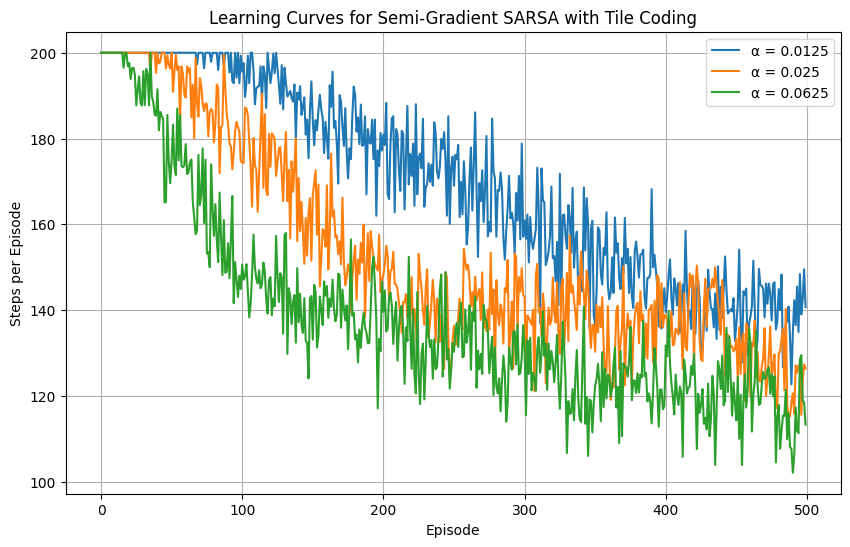

In [ ]:
# Main code to run experiments with Semi-Gradient SARSA on the MountainCar environment
if __name__ == '__main__':
    # Experiment parameters for Figure 10.2: Learning Curves
    num_runs = 10           # Number of runs to average results over for stability
    episode_num = 500       # Number of episodes per run
    alphas = [0.1 / 8, 0.2 / 8, 0.5 / 8]  # Learning rates (alphas) to evaluate
    num_tilings = 8         # Number of tilings for tile coding
    max_size = 4096         # Maximum size for the IHT (collision table)

    all_results = []        # To store results of each alpha configuration

    # Loop over each alpha to evaluate agent performance
    for alpha in alphas:
        steps_per_episode_all_runs = np.zeros(episode_num)  # Accumulator for averaging over runs
        for run in tqdm.trange(num_runs):
            # Set up agent information and environment for each run
            agent_info = {
                'episode_num': episode_num,
                'alpha': alpha,
                'gamma': 1.0,
                'epsilon': 0,           # Deterministic policy (greedy)
                'num_tilings': num_tilings,
                'max_size': max_size
            }
            env = gym.make('MountainCar-v0')  # Initialize the MountainCar environment
            agent = SemiGradientSARSAAgent(env, agent_info)  # Instantiate agent with environment and parameters
            steps_per_episode = agent.run()   # Run the agent and retrieve steps per episode
            steps_per_episode_all_runs += np.array(steps_per_episode)  # Accumulate results across runs
        
        # Average steps per episode over all runs for the current alpha
        steps_per_episode_all_runs /= num_runs
        all_results.append(steps_per_episode_all_runs)

    # Plot learning curves for each alpha value
    plot_learning_curves(all_results, alphas)


  0%|          | 0/9000 [00:00<?, ?it/s]/home/rj/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


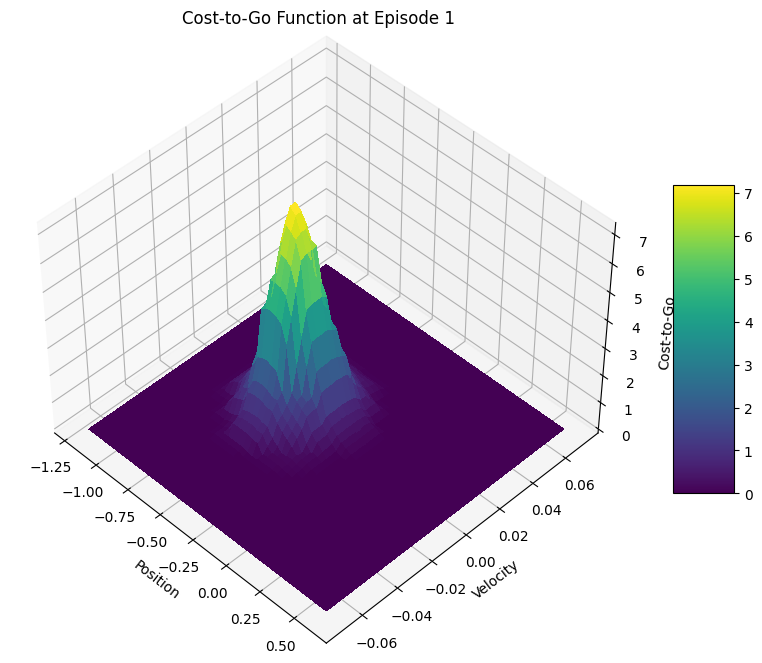

  0%|          | 10/9000 [00:00<07:23, 20.27it/s] 

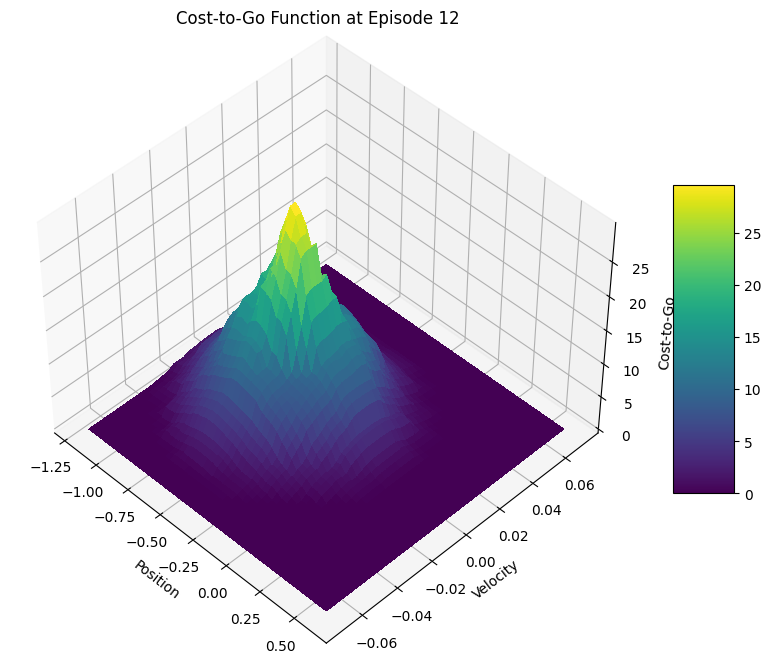

  1%|          | 103/9000 [00:03<02:53, 51.26it/s]

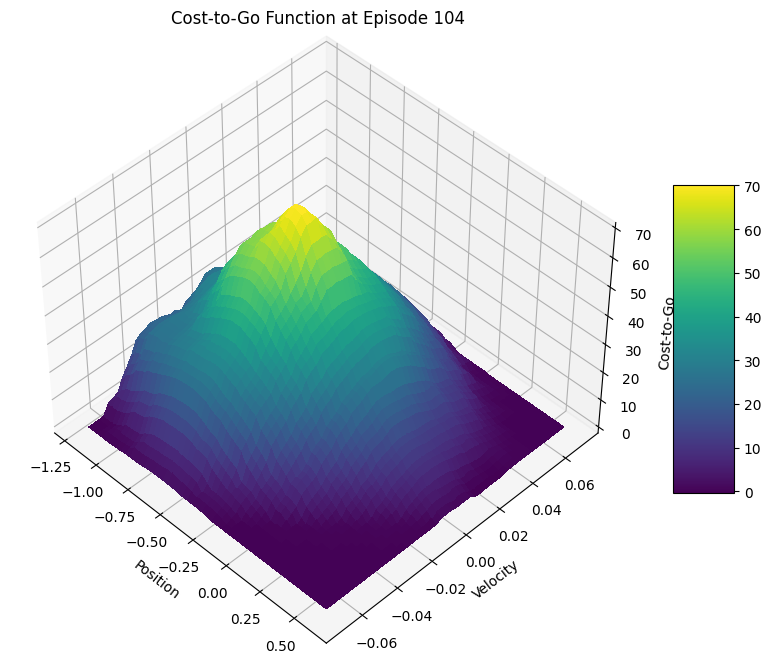

 11%|█         | 995/9000 [00:16<01:59, 66.99it/s]

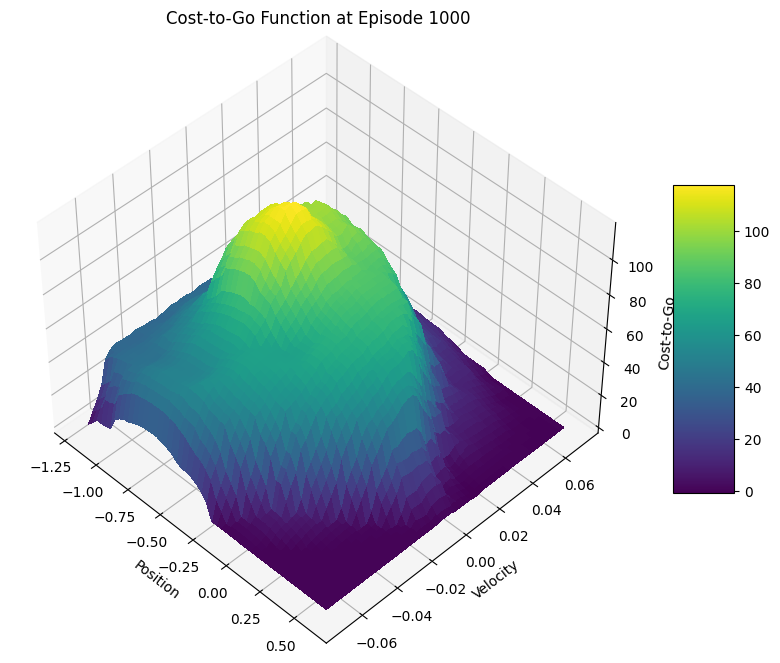

100%|█████████▉| 8994/9000 [02:04<00:00, 75.64it/s]

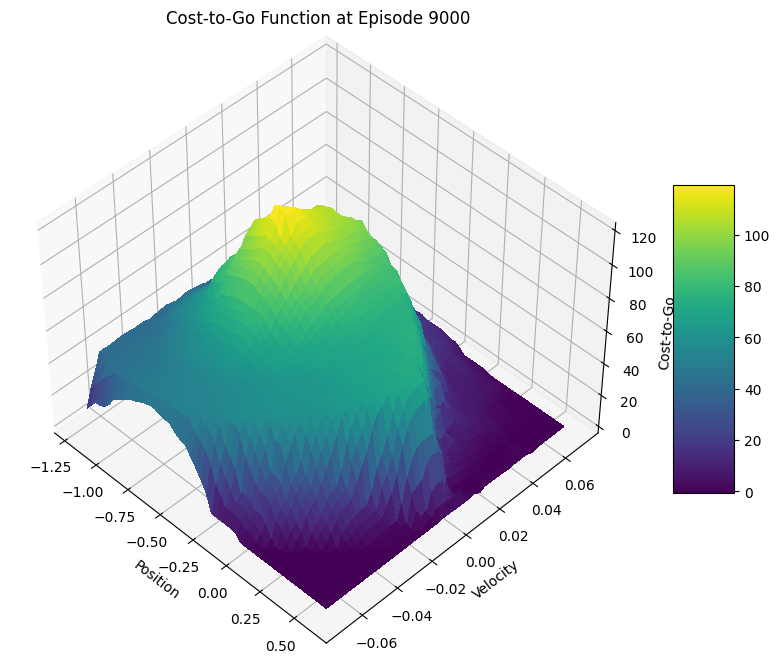

100%|██████████| 9000/9000 [02:05<00:00, 71.83it/s]


In [ ]:
# Code to generate Figure 10.1: 3D Cost-to-Go Function visualizations at various training stages
episode_num = 9000                       # Total number of episodes for training the agent
episodes_to_plot = [1, 12, 104, 1000, 9000]  # Episodes at which to plot the cost-to-go function in 3D
alpha = 0.3 / 8                          # Learning rate (alpha) for the agent
num_tilings = 8                          # Number of tilings for tile coding
max_size = 4096                          # Maximum size of the IHT (collision table)

# Configuration dictionary containing all relevant parameters for initializing the agent
agent_info = {
    'episode_num': episode_num,
    'alpha': alpha,
    'gamma': 1.0,
    'epsilon': 0,                        # Deterministic policy (greedy) 
    'num_tilings': num_tilings,
    'max_size': max_size
}

# Initialize the environment and create the Semi-Gradient SARSA agent with the specified parameters
env = gym.make('MountainCar-v0')
agent = SemiGradientSARSAAgent(env, agent_info)

# Run the agent and visualize the cost-to-go function in 3D for specified episodes
steps_per_episode = run_and_visualize(agent, episodes_to_plot)